### Wind Speed Prediction

#### This is a regression problem in which we will try to predict wind speed.

##### Attribute information

https://www.kaggle.com/datasets/fedesoriano/wind-speed-prediction-dataset

##### Loading the dependencies

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import LinearSVR
from fancyimpute import IterativeImputer
import regex as re

##### Loading the dataset

In [22]:
data = pd.read_csv("wind_dataset.csv")
data.head()

,DATE,WIND,IND,RAIN,IND.1,T.MAX,IND.2,T.MIN,T.MIN.G
0,1961-01-01,13.67,0,0.2,0.0,9.5,0.0,3.7,-1.0
1,1961-01-02,11.50,0,5.1,0.0,7.2,0.0,4.2,1.1
2,1961-01-03,11.25,0,0.4,0.0,5.5,0.0,0.5,-0.5
3,1961-01-04,8.63,0,0.2,0.0,5.6,0.0,0.4,-3.2
4,1961-01-05,11.92,0,10.4,0.0,7.2,1.0,-1.5,-7.5


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6574 entries, 0 to 6573
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DATE     6574 non-null   object 
 1   WIND     6574 non-null   float64
 2   IND      6574 non-null   int64  
 3   RAIN     6574 non-null   float64
 4   IND.1    6513 non-null   float64
 5   T.MAX    5953 non-null   float64
 6   IND.2    6513 non-null   float64
 7   T.MIN    5900 non-null   float64
 8   T.MIN.G  6214 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 462.4+ KB


In [24]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
WIND,6574.0,9.796834,4.977272,0.0,6.0,9.21,12.96,30.37
IND,6574.0,0.391542,1.179092,0.0,0.0,0.00,0.00,4.00
RAIN,6574.0,1.885169,4.030529,0.0,0.0,0.20,2.00,67.00
IND.1,6513.0,0.356364,1.128552,0.0,0.0,0.00,0.00,4.00
T.MAX,5953.0,13.339123,4.890546,-0.1,9.6,13.30,17.20,26.80
IND.2,6513.0,0.464456,1.177571,0.0,0.0,0.00,0.00,4.00
T.MIN,5900.0,6.411678,4.637243,-11.5,3.0,6.50,10.00,18.00
T.MIN.G,6214.0,2.736547,5.569175,-14.4,-1.0,3.00,7.00,15.80


In [25]:
data.shape

(6574, 9)

#### Data preprocessing

##### Renaming the columns

In [26]:
data.rename(columns={'IND.1':"IND_1", 'T.MAX':"T_MAX", 'IND.2':"IND_2", 'T.MIN':"T_MIN",
       'T.MIN.G':"T_MIN_G"}, inplace=True)

In [27]:
data.head()

,DATE,WIND,IND,RAIN,IND_1,T_MAX,IND_2,T_MIN,T_MIN_G
0,1961-01-01,13.67,0,0.2,0.0,9.5,0.0,3.7,-1.0
1,1961-01-02,11.50,0,5.1,0.0,7.2,0.0,4.2,1.1
2,1961-01-03,11.25,0,0.4,0.0,5.5,0.0,0.5,-0.5
3,1961-01-04,8.63,0,0.2,0.0,5.6,0.0,0.4,-3.2
4,1961-01-05,11.92,0,10.4,0.0,7.2,1.0,-1.5,-7.5


##### Wind over the years

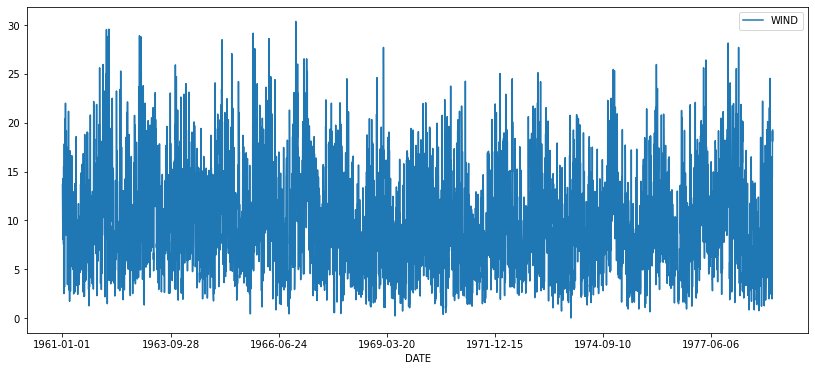

In [28]:
data.plot(x='DATE',y='WIND',figsize=(14,6));

##### Change the data type of DATE column 

In [29]:
data["DATE"] = pd.to_datetime(data.DATE)

#### Extract day, month and year from the DATE column

In [30]:
data["Day"] = data["DATE"].dt.day
data["Month"] = data["DATE"].dt.month
data["Year"] = data["DATE"].dt.year

##### Lets drop the DATE column

In [31]:
data.drop(columns="DATE", inplace=True)

In [32]:
data.head()

,WIND,IND,RAIN,IND_1,T_MAX,IND_2,T_MIN,T_MIN_G,Day,Month,Year
0,13.67,0,0.2,0.0,9.5,0.0,3.7,-1.0,1,1,1961
1,11.50,0,5.1,0.0,7.2,0.0,4.2,1.1,2,1,1961
2,11.25,0,0.4,0.0,5.5,0.0,0.5,-0.5,3,1,1961
3,8.63,0,0.2,0.0,5.6,0.0,0.4,-3.2,4,1,1961
4,11.92,0,10.4,0.0,7.2,1.0,-1.5,-7.5,5,1,1961


In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6574 entries, 0 to 6573
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   WIND     6574 non-null   float64
 1   IND      6574 non-null   int64  
 2   RAIN     6574 non-null   float64
 3   IND_1    6513 non-null   float64
 4   T_MAX    5953 non-null   float64
 5   IND_2    6513 non-null   float64
 6   T_MIN    5900 non-null   float64
 7   T_MIN_G  6214 non-null   float64
 8   Day      6574 non-null   int64  
 9   Month    6574 non-null   int64  
 10  Year     6574 non-null   int64  
dtypes: float64(7), int64(4)
memory usage: 565.1 KB


#### Data Visualization

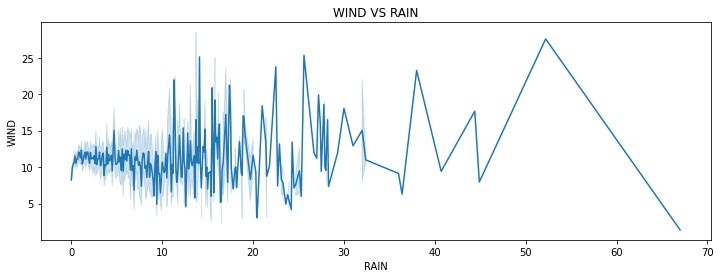

In [34]:
plt.figure(figsize=(12,4))
plt.title("WIND VS RAIN")
sns.lineplot(data=data, x="RAIN", y="WIND");

##### Null data percentage

In [35]:
null_percent = data.isnull().mean()*100
null_percent

WIND        0.000000
IND         0.000000
RAIN        0.000000
IND_1       0.927898
T_MAX       9.446304
IND_2       0.927898
T_MIN      10.252510
T_MIN_G     5.476118
Day         0.000000
Month       0.000000
Year        0.000000
dtype: float64

##### Impute the missing data using Iterative imputer

In [36]:
data_mice = data.copy(deep=True)

In [37]:
mice = IterativeImputer()

In [38]:
data_mice.iloc[:,:] = mice.fit_transform(data_mice)

In [39]:
data_mice.isnull().sum()

WIND       0
IND        0
RAIN       0
IND_1      0
T_MAX      0
IND_2      0
T_MIN      0
T_MIN_G    0
Day        0
Month      0
Year       0
dtype: int64

In [40]:
data_mice.head()

,WIND,IND,RAIN,IND_1,T_MAX,IND_2,T_MIN,T_MIN_G,Day,Month,Year
0,13.67,0.0,0.2,0.0,9.5,0.0,3.7,-1.0,1.0,1.0,1961.0
1,11.50,0.0,5.1,0.0,7.2,0.0,4.2,1.1,2.0,1.0,1961.0
2,11.25,0.0,0.4,0.0,5.5,0.0,0.5,-0.5,3.0,1.0,1961.0
3,8.63,0.0,0.2,0.0,5.6,0.0,0.4,-3.2,4.0,1.0,1961.0
4,11.92,0.0,10.4,0.0,7.2,1.0,-1.5,-7.5,5.0,1.0,1961.0


In [41]:
#### After the imputation some column data types are changed. Lets change it back to normal.

In [42]:
data_mice["IND"] = data_mice["IND"].astype("int")
data_mice["Month"] = data_mice["Month"].astype("int")
data_mice["Day"] = data_mice["Day"].astype("int")
data_mice["Year"] = data_mice["Year"].astype("int")

In [43]:
data_mice.head()

,WIND,IND,RAIN,IND_1,T_MAX,IND_2,T_MIN,T_MIN_G,Day,Month,Year
0,13.67,0,0.2,0.0,9.5,0.0,3.7,-1.0,1,1,1961
1,11.50,0,5.1,0.0,7.2,0.0,4.2,1.1,2,1,1961
2,11.25,0,0.4,0.0,5.5,0.0,0.5,-0.5,3,1,1961
3,8.63,0,0.2,0.0,5.6,0.0,0.4,-3.2,4,1,1961
4,11.92,0,10.4,0.0,7.2,1.0,-1.5,-7.5,5,1,1961


##### Checking outliers

##### Box plot

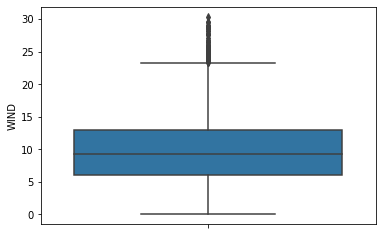

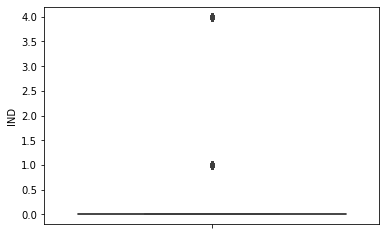

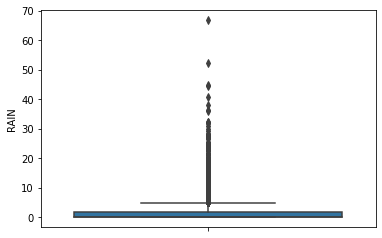

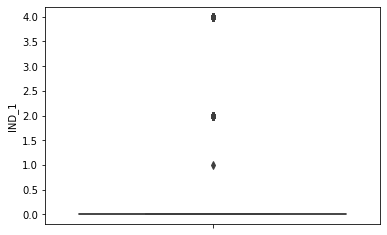

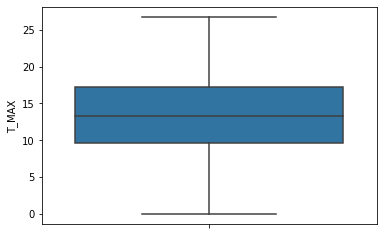

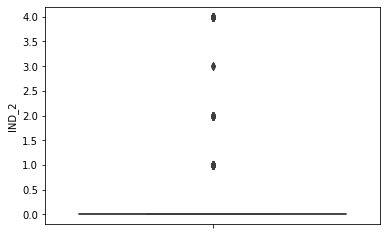

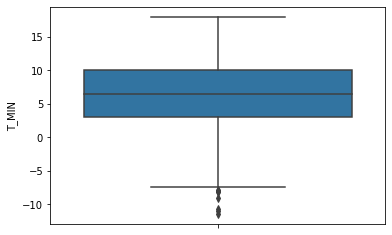

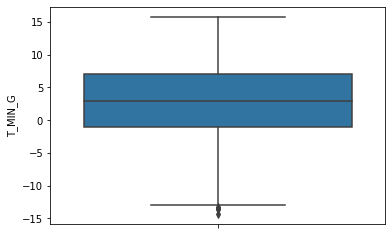

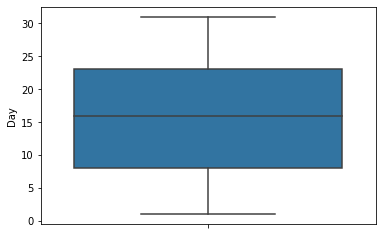

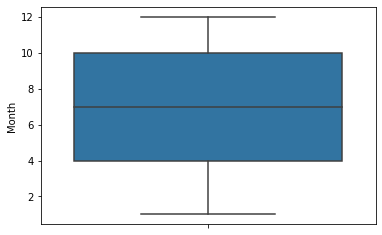

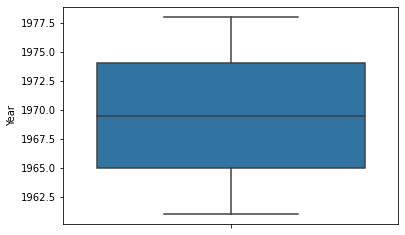

In [44]:
for i in data_mice.columns:
    sns.boxplot(y=data[i])
    plt.show();

In [45]:
#### Setting the outluer limits 

In [46]:
def outlier_limt(col):
    Q3,Q1 = np.nanpercentile(col, [75,25])
    IQR = Q3 - Q1
    UL = Q3+1.5*IQR
    LL = Q1-1.5*IQR
    return UL, LL

In [47]:
for i in data_mice.columns:
    UL, LL = outlier_limt(data_mice[i])
    data_mice[i] = np.where((data_mice[i]>UL)|(data_mice[i]<LL), np.nan, data[i])

In [48]:
data_mice.isnull().sum()

WIND         66
IND         681
RAIN        740
IND_1       662
T_MAX       621
IND_2      1222
T_MIN       678
T_MIN_G     367
Day           0
Month         0
Year          0
dtype: int64

In [49]:
data_mice.dropna(inplace=True)

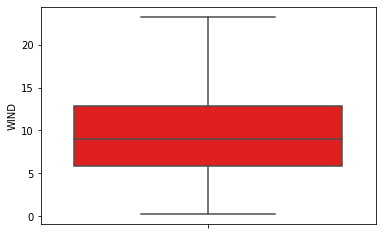

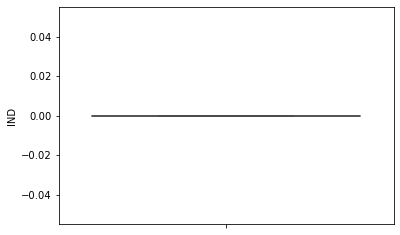

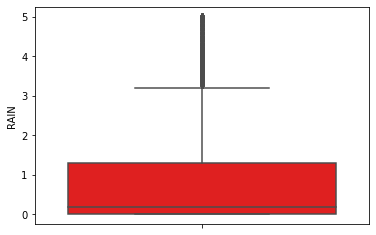

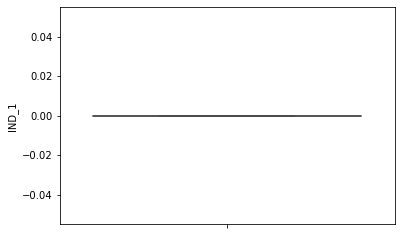

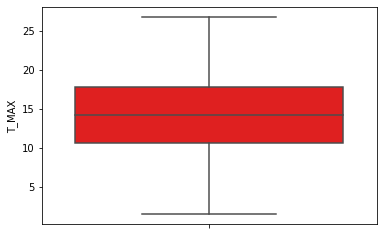

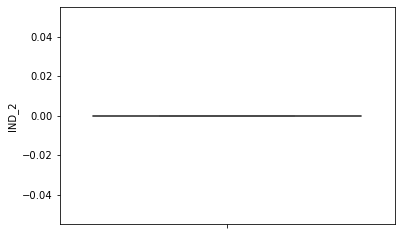

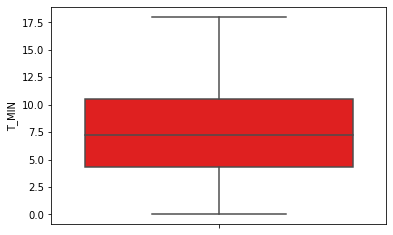

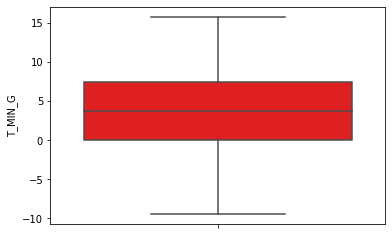

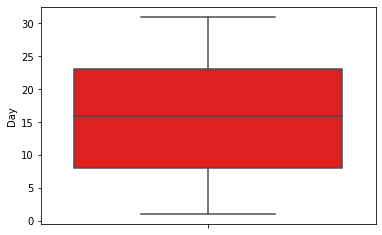

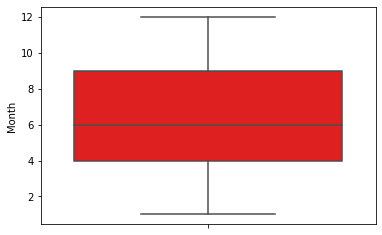

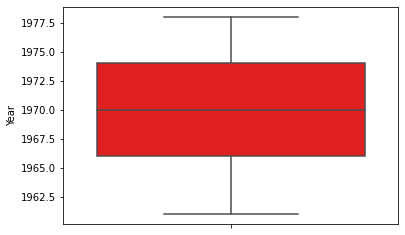

In [50]:
for i in data_mice.columns:
    sns.boxplot(y=data_mice[i], color="Red")
    plt.show();

In [51]:
data_mice.shape

(3979, 11)

In [52]:
data.shape

(6574, 11)

#### Histogram

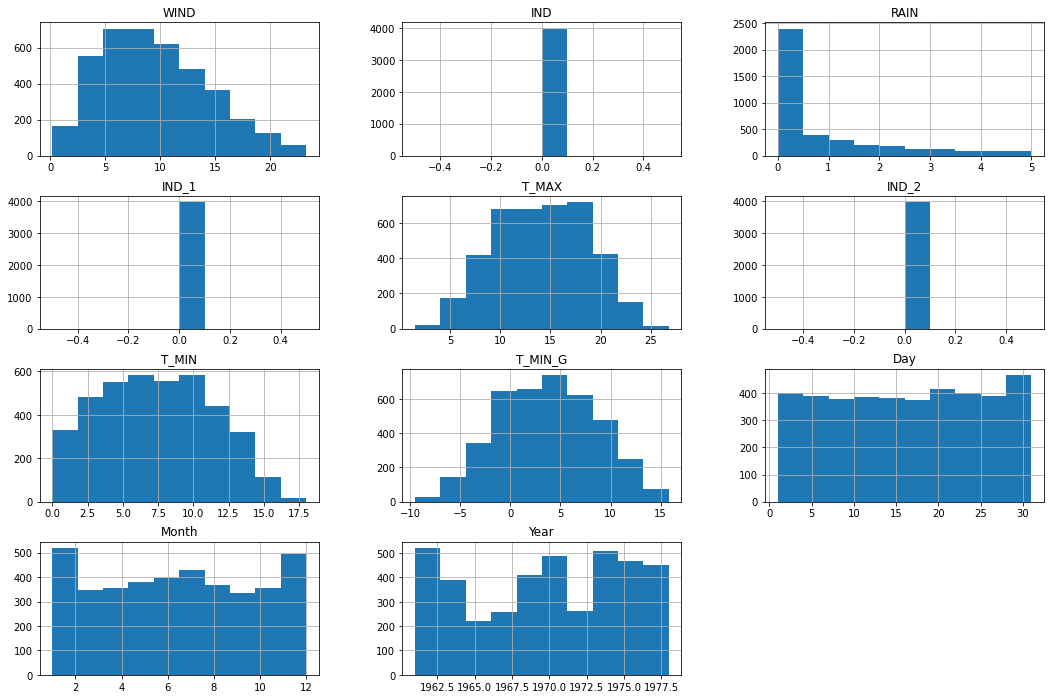

In [53]:
data_mice.hist(figsize=(18,12));

#### Correlation matrix

<AxesSubplot:>

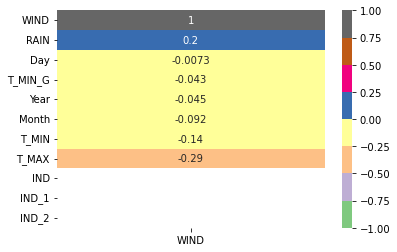

In [54]:
sns.heatmap(data_mice.corr()[["WIND"]].sort_values(by="WIND", ascending=False), vmax=1, vmin=-1, annot=True, cmap="Accent")

#### We can see that only RAIN is  are positively correlated to WIND

#### Features into x and y

In [55]:
x = data_mice.drop(["WIND"], axis=1).values
y = data_mice["WIND"].values

#### Scaling the data

In [56]:
sc = StandardScaler()

In [57]:
x = sc.fit_transform(x)

#### Splitting into training and testing 

In [58]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

#### Model building

In [59]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge":Ridge(),
    "LinearSVR":LinearSVR(),
    "DecisionTreeRegressor":DecisionTreeRegressor(),
    "GradientBoostingRegressor":GradientBoostingRegressor(),
    "AdaBoostRegressor":AdaBoostRegressor(),
    "RandomForestRegressor":RandomForestRegressor(random_state=0),
}

In [60]:
for name, model in models.items():
    model.fit(x_train, y_train)
    print("model trained with {}".format(name))
    training_score = model.score(x_train, y_train)*100
    testing_score = model.score(x_test, y_test)*100
    score = r2_score(y_test, model.predict(x_test))*100
    mae = mean_absolute_error(y_test, model.predict(x_test))
    mse = mean_squared_error(y_test, model.predict(x_test))
    rmse = np.sqrt(mse)
    print("r2score: ",score)
    print("training_score: ", training_score)
    print("testing_score: ", testing_score)
    print("mae: ", mae)
    print("mse: ", mse)
    print("rmse_test: ", rmse)
    print("*"*100)

model trained with LinearRegression
r2score:  14.048928465628075
training_score:  14.578886305432825
testing_score:  14.048928465628075
mae:  3.493303647556664
mse:  18.854434148885552
rmse_test:  4.34216929067552
****************************************************************************************************
model trained with Ridge
r2score:  14.049341506281909
training_score:  14.578881344572302
testing_score:  14.049341506281909
mae:  3.493342471939071
mse:  18.854343543292515
rmse_test:  4.342158857445512
****************************************************************************************************
model trained with LinearSVR
r2score:  13.017139633736152
training_score:  13.69916010028045
testing_score:  13.017139633736152
mae:  3.4753017173834335
mse:  19.080769833120534
rmse_test:  4.36815405327245
****************************************************************************************************
model trained with DecisionTreeRegressor
r2score:  -62.20975690620549
tr

##### GradientBoostingRegressor is having the best perfomance. Lets use it to predict wind speed.

In [61]:
GBR = GradientBoostingRegressor(random_state=0)

In [62]:
GBR.fit(x_train, y_train)

GradientBoostingRegressor(random_state=0)

In [63]:
y_pred = GBR.predict(x_test)

In [64]:
OUTPUT = pd.DataFrame(zip(y,y_pred), columns=("ACTUAL", "PREDICTED"))
OUTPUT.head()

,ACTUAL,PREDICTED
0,13.67,7.923410
1,11.25,8.933925
2,8.63,10.024095
3,10.67,9.854089
4,14.29,9.910549
